<a href="https://colab.research.google.com/github/hanbii4167/Crawling/blob/main/%E1%84%8C%E1%85%A5%E1%86%BC%E1%84%89%E1%85%A5%E1%86%BC%E1%84%92%E1%85%A9_vs_%E1%84%8B%E1%85%B5%E1%86%B7%E1%84%8C%E1%85%A2%E1%84%87%E1%85%A5%E1%86%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. 데이터 준비하기**
* 정성호, 임재범 사진 각각 500개 크롤링
* 구글, 네이버사진

In [3]:
!pip install timm

In [18]:
import random
import os
import shutil
import cv2
import glob
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import timm
# 파이썬에서 다양한 이미지 분류 모델을 제공하는 라이브러리로 사전 학습된 모델과 다양한 최신 아키텍쳐를 쉽게 사용할 수 있게 함
import timm
from tqdm import tqdm
from time import time
from torchvision import datasets, models, transforms
from tempfile import TemporaryDirectory
from torch.optim import lr_scheduler

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
data_root = '/content/drive/MyDrive/컵퓨터비전 시즌4/6. 프로젝트/5.  정성호 vs 임재범'
file_root = f'{data_root}/data'

train_root = f'{data_root}/train'
valid_root = f'{data_root}/valid'
test_root = f'{data_root}/test'

cls_list = os.listdir(file_root)
print(cls_list)

['Lim', 'Jung']


In [13]:
for folder in [train_root, valid_root, test_root]:
    if not os.path.exists(folder):
        os.makedirs(folder)
    for cls in cls_list:
        cls_folder = f'{folder}/{cls}'
        if not os.path.exists(cls_folder):
            os.makedirs(cls_folder)

In [14]:
random.seed(2024)

In [15]:
for cls in cls_list:
    file_list = os.listdir(f'{file_root}/{cls}')
    random.shuffle(file_list)
    test_ratio = 0.1
    num_file = len(file_list)

    test_list = file_list[:int(num_file*test_ratio)]
    valid_list = file_list[int(num_file*test_ratio):int(num_file*test_ratio)*2]
    train_list = file_list[int(num_file*test_ratio)*2:]

    for i in test_list:
        shutil.copyfile(f'{file_root}/{cls}/{i}', f'{test_root}/{cls}/{i}')

    for i in valid_list:
        shutil.copyfile(f'{file_root}/{cls}/{i}', f'{valid_root}/{cls}/{i}')

    for i in train_list:
        shutil.copyfile(f'{file_root}/{cls}/{i}', f'{train_root}/{cls}/{i}')

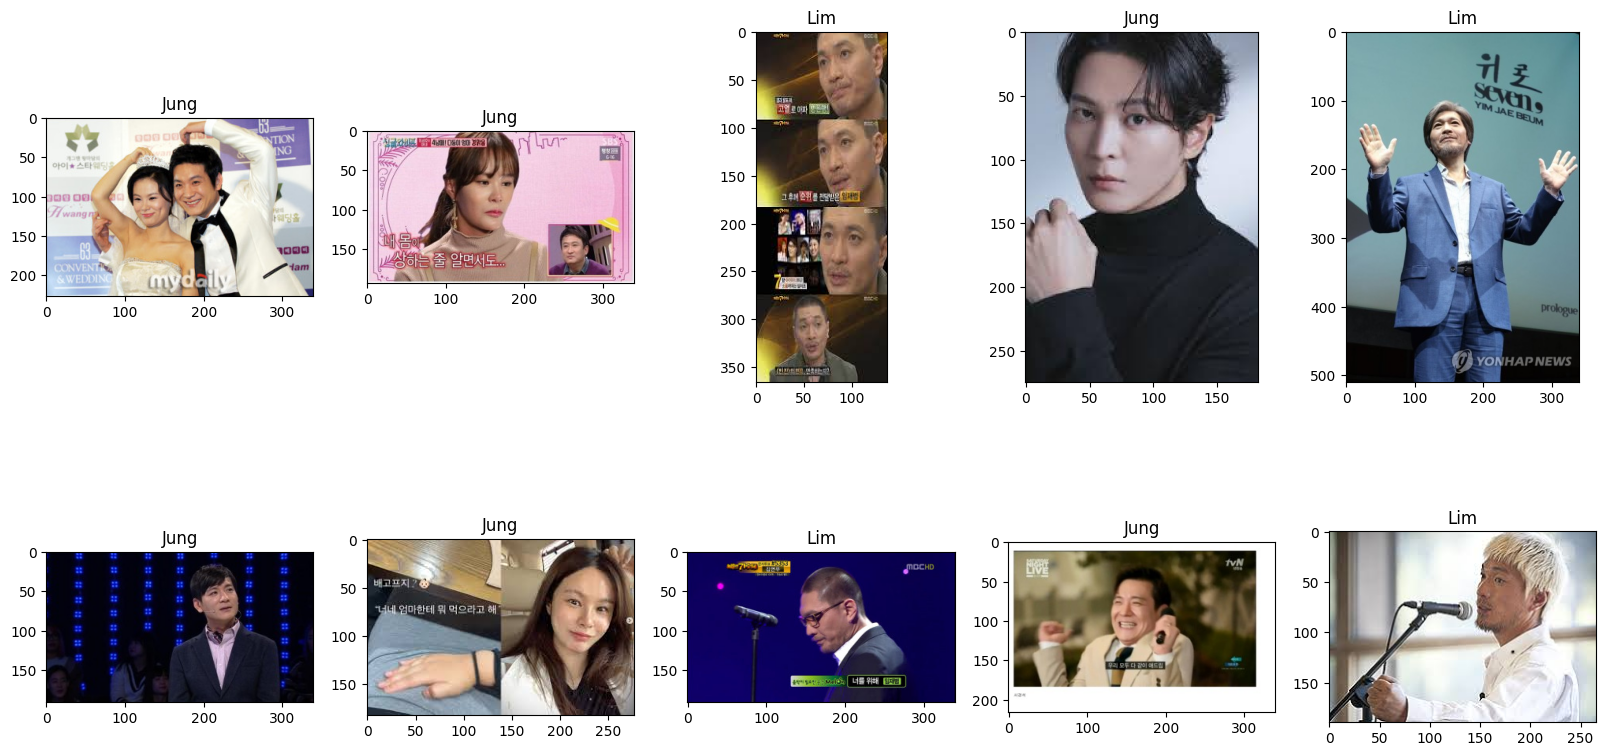

In [19]:
import matplotlib.pyplot as plt
import glob
from PIL import Image

test_file_list = glob.glob(f"{test_root}/*/*")
random.shuffle(test_file_list)

plt.figure(figsize = (20,10))
for i in range(10):
    test_img_path = os.path.join(test_root, test_file_list[i])
    ori_img = Image.open(test_img_path).convert('RGB')
    plt.subplot(2, 5, (i+1))
    plt.title(test_file_list[i].split('/')[-2])
    plt.imshow(ori_img)

plt.show()

In [20]:
IMG_SIZE = (224, 224)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [21]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_root, x),
                                          data_transforms[x])
                    for x in ['train', 'valid', 'test']}

In [22]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True)
                    for x in ['train', 'valid', 'test']}

In [23]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

{'train': 800, 'valid': 100, 'test': 100}
['Jung', 'Lim']


In [24]:
data_root = '/content/drive/MyDrive/컵퓨터비전 시즌4/6. 프로젝트/5.  정성호 vs 임재범'
file_root = f'{data_root}/data'
test_root = f'{data_root}/test'

test_file_list = glob.glob(f'{test_root}/*/*')
random.shuffle(test_file_list)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


100
['Jung', 'Lim']


In [53]:

def train_model(model, loss_func, optimizer, dataloader, datasets_size,model_dir, model_name, num_epochs, device):
    since = time()

    # 임시 디렉토리를 생성하고 작업이 끝난 후 자동으로 삭제하도록 관리
    with TemporaryDirectory() as tempdir:
      best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
      print(best_model_params_path)
      torch.save(model.state_dict(), best_model_params_path)
      best_acc = 0.0
      train_loss = []
      train_acc = []
      valid_loss = []
      valid_acc = []

      for epoch in range(num_epochs):
          print(f'Epoch {epoch+1}/{num_epochs}')
          print('-' * 10)

          for phase in ['train', 'valid']:
              if phase == 'train':
                  model.train()
              else:
                  model.eval()

              running_loss = 0.0
              running_corrects = 0

              for inputs, labels in tqdm(dataloader[phase]):
                  inputs = inputs.to(device)
                  labels = labels.to(device)
                  optimizer.zero_grad()

                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs)
                      _, preds = torch.max(outputs, 1)
                      loss = loss_func(outputs, labels)
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()

                  running_loss += loss.item() * inputs.size(0)
                  running_corrects += torch.sum(preds == labels.data)

              if phase == 'train':
                scheduler.step()

              epoch_loss = running_loss / datasets_size[phase]
              epoch_acc = running_corrects.double() / datasets_size[phase]

              print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

              if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.item())
              else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc.item())
                if epoch_acc > best_acc:
                  best_acc = epoch_acc

                  if not os.path.exists(model_dir):
                    os.makedirs(model_dir)

                  model_save_path = os.path.join(model_dir, f'{model_name}.pth')
                  torch.save(model.state_dict(), model_save_path)

          print()

      time_elapsed = time() - since
      print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
      print(f'Best val Acc: {best_acc:4f}')

    return [train_loss, train_acc, valid_loss, valid_acc]

In [54]:
project_root = '/content/drive/MyDrive/컵퓨터비전 시즌4/6. 프로젝트/5.  정성호 vs 임재범'
if not os.path.exists(project_root):
    os.makedirs(project_root)
model_dir = f'{project_root}/model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

num_epochs = 100
num_class = len(os.listdir(train_root))
loss_func = nn.CrossEntropyLoss()
resnet34_model = timm.create_model('resnet34', pretrained=True, num_classes=num_class).to(device)
optimizer = optim.Adam(resnet34_model.parameters(), lr=0.0001)
# 학습률 스케쥴러
# 학습 중에 학습률을 점진적으로 조정할 수 있음
# StepLR : 일정한 에포크 수 마다 학습률을 감소시키는 역할
# step_size : 학습률을 조정하는 주기. 예) 매 10 에포크마다 학습률이 감소
# gamma :  학습률을 감소시키는 비율. 예) 초기 학습률이 0.1 이었다면 10에포크 후에 0.01로 줄어듬
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [55]:
resnet34 = train_model(resnet34_model, loss_func, optimizer, dataloaders , dataset_sizes, model_dir,  "jshljb_resnet34", num_epochs, device)

/tmp/tmp8suytemz/best_model_params.pt
Epoch 1/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


train Loss: 0.6596 Acc: 0.6288


100%|██████████| 7/7 [00:00<00:00,  9.55it/s]


valid Loss: 0.6281 Acc: 0.7300

Epoch 2/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.05it/s]


train Loss: 0.5267 Acc: 0.8900


100%|██████████| 7/7 [00:00<00:00,  9.39it/s]


valid Loss: 0.5150 Acc: 0.8000

Epoch 3/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


train Loss: 0.3585 Acc: 0.9250


100%|██████████| 7/7 [00:00<00:00,  8.29it/s]


valid Loss: 0.4146 Acc: 0.8400

Epoch 4/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.34it/s]


train Loss: 0.2267 Acc: 0.9450


100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


valid Loss: 0.3459 Acc: 0.8600

Epoch 5/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.42it/s]


train Loss: 0.1310 Acc: 0.9825


100%|██████████| 7/7 [00:00<00:00,  8.69it/s]


valid Loss: 0.3286 Acc: 0.8600

Epoch 6/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.07it/s]


train Loss: 0.0942 Acc: 0.9813


100%|██████████| 7/7 [00:00<00:00,  9.75it/s]


valid Loss: 0.3113 Acc: 0.8700

Epoch 7/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.15it/s]


train Loss: 0.0617 Acc: 0.9913


100%|██████████| 7/7 [00:00<00:00,  8.75it/s]


valid Loss: 0.2826 Acc: 0.8800

Epoch 8/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.19it/s]


train Loss: 0.0462 Acc: 0.9925


100%|██████████| 7/7 [00:00<00:00,  8.58it/s]


valid Loss: 0.2877 Acc: 0.9000

Epoch 9/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.48it/s]


train Loss: 0.0360 Acc: 0.9938


100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


valid Loss: 0.3250 Acc: 0.8900

Epoch 10/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.05it/s]


train Loss: 0.0306 Acc: 0.9962


100%|██████████| 7/7 [00:00<00:00,  9.82it/s]


valid Loss: 0.2681 Acc: 0.9000

Epoch 11/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.22it/s]


train Loss: 0.0240 Acc: 0.9975


100%|██████████| 7/7 [00:00<00:00,  9.52it/s]


valid Loss: 0.2799 Acc: 0.9000

Epoch 12/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


train Loss: 0.0246 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.17it/s]


valid Loss: 0.2827 Acc: 0.8900

Epoch 13/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.53it/s]


train Loss: 0.0255 Acc: 0.9962


100%|██████████| 7/7 [00:00<00:00,  7.81it/s]


valid Loss: 0.2828 Acc: 0.8900

Epoch 14/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.44it/s]


train Loss: 0.0340 Acc: 0.9938


100%|██████████| 7/7 [00:00<00:00,  9.51it/s]


valid Loss: 0.2840 Acc: 0.9000

Epoch 15/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.39it/s]


train Loss: 0.0211 Acc: 0.9975


100%|██████████| 7/7 [00:00<00:00,  9.82it/s]


valid Loss: 0.2807 Acc: 0.8900

Epoch 16/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.44it/s]


train Loss: 0.0149 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  7.75it/s]


valid Loss: 0.2950 Acc: 0.8900

Epoch 17/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.54it/s]


train Loss: 0.0209 Acc: 0.9975


100%|██████████| 7/7 [00:00<00:00,  9.36it/s]


valid Loss: 0.2906 Acc: 0.9000

Epoch 18/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.23it/s]


train Loss: 0.0158 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.54it/s]


valid Loss: 0.2852 Acc: 0.8900

Epoch 19/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


train Loss: 0.0187 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.64it/s]


valid Loss: 0.2929 Acc: 0.8900

Epoch 20/100
----------


100%|██████████| 50/50 [00:11<00:00,  4.47it/s]


train Loss: 0.0132 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.57it/s]


valid Loss: 0.2934 Acc: 0.8900

Epoch 21/100
----------


100%|██████████| 50/50 [00:08<00:00,  5.57it/s]


train Loss: 0.0138 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  7.11it/s]


valid Loss: 0.2877 Acc: 0.9000

Epoch 22/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.73it/s]


train Loss: 0.0175 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.45it/s]


valid Loss: 0.3035 Acc: 0.8900

Epoch 23/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.22it/s]


train Loss: 0.0166 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.34it/s]


valid Loss: 0.2940 Acc: 0.8900

Epoch 24/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.31it/s]


train Loss: 0.0158 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.19it/s]


valid Loss: 0.2889 Acc: 0.9000

Epoch 25/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.52it/s]


train Loss: 0.0253 Acc: 0.9950


100%|██████████| 7/7 [00:00<00:00,  8.08it/s]


valid Loss: 0.2964 Acc: 0.8900

Epoch 26/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.33it/s]


train Loss: 0.0253 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.52it/s]


valid Loss: 0.2910 Acc: 0.8900

Epoch 27/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


train Loss: 0.0177 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.13it/s]


valid Loss: 0.3024 Acc: 0.8900

Epoch 28/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


train Loss: 0.0128 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  9.35it/s]


valid Loss: 0.2868 Acc: 0.8900

Epoch 29/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.54it/s]


train Loss: 0.0118 Acc: 1.0000


100%|██████████| 7/7 [00:01<00:00,  4.89it/s]


valid Loss: 0.2901 Acc: 0.8900

Epoch 30/100
----------


100%|██████████| 50/50 [00:11<00:00,  4.26it/s]


train Loss: 0.0128 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  8.47it/s]


valid Loss: 0.2935 Acc: 0.9000

Epoch 31/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.89it/s]


train Loss: 0.0195 Acc: 0.9962


100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


valid Loss: 0.2991 Acc: 0.9000

Epoch 32/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.94it/s]


train Loss: 0.0184 Acc: 0.9975


100%|██████████| 7/7 [00:01<00:00,  6.13it/s]


valid Loss: 0.2888 Acc: 0.8900

Epoch 33/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.56it/s]


train Loss: 0.0207 Acc: 0.9962


100%|██████████| 7/7 [00:00<00:00,  8.59it/s]


valid Loss: 0.2913 Acc: 0.8900

Epoch 34/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.39it/s]


train Loss: 0.0130 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


valid Loss: 0.2979 Acc: 0.9000

Epoch 35/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.05it/s]


train Loss: 0.0191 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  8.78it/s]


valid Loss: 0.2944 Acc: 0.9000

Epoch 36/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.00it/s]


train Loss: 0.0139 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  8.71it/s]


valid Loss: 0.2957 Acc: 0.8900

Epoch 37/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.70it/s]


train Loss: 0.0140 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.07it/s]


valid Loss: 0.2865 Acc: 0.8900

Epoch 38/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.30it/s]


train Loss: 0.0136 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  7.23it/s]


valid Loss: 0.2930 Acc: 0.9100

Epoch 39/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.03it/s]


train Loss: 0.0214 Acc: 0.9962


100%|██████████| 7/7 [00:00<00:00,  7.19it/s]


valid Loss: 0.2909 Acc: 0.8900

Epoch 40/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


train Loss: 0.0174 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.34it/s]


valid Loss: 0.2864 Acc: 0.8900

Epoch 41/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]


train Loss: 0.0192 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.36it/s]


valid Loss: 0.2868 Acc: 0.8900

Epoch 42/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


train Loss: 0.0154 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  9.04it/s]


valid Loss: 0.2892 Acc: 0.9100

Epoch 43/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


train Loss: 0.0134 Acc: 1.0000


100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


valid Loss: 0.2978 Acc: 0.9000

Epoch 44/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.16it/s]


train Loss: 0.0180 Acc: 0.9950


100%|██████████| 7/7 [00:00<00:00,  8.26it/s]


valid Loss: 0.3001 Acc: 0.9000

Epoch 45/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.11it/s]


train Loss: 0.0132 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  9.61it/s]


valid Loss: 0.2921 Acc: 0.8900

Epoch 46/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


train Loss: 0.0186 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.45it/s]


valid Loss: 0.2963 Acc: 0.9000

Epoch 47/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.31it/s]


train Loss: 0.0139 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


valid Loss: 0.2950 Acc: 0.8900

Epoch 48/100
----------


100%|██████████| 50/50 [00:08<00:00,  5.56it/s]


train Loss: 0.0148 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  8.82it/s]


valid Loss: 0.3071 Acc: 0.8900

Epoch 49/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.83it/s]


train Loss: 0.0193 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  9.47it/s]


valid Loss: 0.2914 Acc: 0.8900

Epoch 50/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.25it/s]


train Loss: 0.0192 Acc: 0.9962


100%|██████████| 7/7 [00:00<00:00,  9.32it/s]


valid Loss: 0.2870 Acc: 0.9100

Epoch 51/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]


train Loss: 0.0158 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  9.45it/s]


valid Loss: 0.2885 Acc: 0.9000

Epoch 52/100
----------


100%|██████████| 50/50 [00:08<00:00,  5.60it/s]


train Loss: 0.0145 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  8.53it/s]


valid Loss: 0.3055 Acc: 0.9100

Epoch 53/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.99it/s]


train Loss: 0.0144 Acc: 0.9975


100%|██████████| 7/7 [00:00<00:00,  9.39it/s]


valid Loss: 0.2901 Acc: 0.9000

Epoch 54/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


train Loss: 0.0237 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.35it/s]


valid Loss: 0.3046 Acc: 0.9000

Epoch 55/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.89it/s]


train Loss: 0.0118 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.57it/s]


valid Loss: 0.2888 Acc: 0.8900

Epoch 56/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.50it/s]


train Loss: 0.0190 Acc: 0.9975


100%|██████████| 7/7 [00:00<00:00,  7.84it/s]


valid Loss: 0.2905 Acc: 0.8900

Epoch 57/100
----------


100%|██████████| 50/50 [00:11<00:00,  4.50it/s]


train Loss: 0.0132 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  8.57it/s]


valid Loss: 0.2915 Acc: 0.9000

Epoch 58/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.09it/s]


train Loss: 0.0190 Acc: 0.9975


100%|██████████| 7/7 [00:00<00:00,  9.17it/s]


valid Loss: 0.2980 Acc: 0.8900

Epoch 59/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.97it/s]


train Loss: 0.0170 Acc: 0.9988


100%|██████████| 7/7 [00:01<00:00,  6.66it/s]


valid Loss: 0.2961 Acc: 0.8900

Epoch 60/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.90it/s]


train Loss: 0.0174 Acc: 0.9975


100%|██████████| 7/7 [00:00<00:00,  7.07it/s]


valid Loss: 0.2926 Acc: 0.9000

Epoch 61/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.98it/s]


train Loss: 0.0134 Acc: 0.9988


100%|██████████| 7/7 [00:01<00:00,  6.04it/s]


valid Loss: 0.2953 Acc: 0.8900

Epoch 62/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


train Loss: 0.0168 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.08it/s]


valid Loss: 0.2952 Acc: 0.8900

Epoch 63/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.95it/s]


train Loss: 0.0152 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  7.48it/s]


valid Loss: 0.2901 Acc: 0.9000

Epoch 64/100
----------


100%|██████████| 50/50 [00:11<00:00,  4.48it/s]


train Loss: 0.0136 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  7.18it/s]


valid Loss: 0.2950 Acc: 0.8900

Epoch 65/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.78it/s]


train Loss: 0.0155 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  9.19it/s]


valid Loss: 0.2923 Acc: 0.8900

Epoch 66/100
----------


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]


train Loss: 0.0125 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  7.38it/s]


valid Loss: 0.2932 Acc: 0.8900

Epoch 67/100
----------


100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


train Loss: 0.0166 Acc: 0.9988


100%|██████████| 7/7 [00:01<00:00,  4.35it/s]


valid Loss: 0.2982 Acc: 0.9000

Epoch 68/100
----------


100%|██████████| 50/50 [00:12<00:00,  4.16it/s]


train Loss: 0.0156 Acc: 0.9988


100%|██████████| 7/7 [00:01<00:00,  6.19it/s]


valid Loss: 0.2912 Acc: 0.8900

Epoch 69/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.24it/s]


train Loss: 0.0202 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.15it/s]


valid Loss: 0.2889 Acc: 0.9000

Epoch 70/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.60it/s]


train Loss: 0.0169 Acc: 0.9975


100%|██████████| 7/7 [00:00<00:00,  9.29it/s]


valid Loss: 0.3014 Acc: 0.8900

Epoch 71/100
----------


100%|██████████| 50/50 [00:11<00:00,  4.21it/s]


train Loss: 0.0152 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  7.87it/s]


valid Loss: 0.2911 Acc: 0.8900

Epoch 72/100
----------


100%|██████████| 50/50 [00:11<00:00,  4.54it/s]


train Loss: 0.0194 Acc: 0.9988


100%|██████████| 7/7 [00:01<00:00,  4.41it/s]


valid Loss: 0.2861 Acc: 0.9000

Epoch 73/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.46it/s]


train Loss: 0.0131 Acc: 0.9988


100%|██████████| 7/7 [00:01<00:00,  6.25it/s]


valid Loss: 0.2825 Acc: 0.8900

Epoch 74/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]


train Loss: 0.0149 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  8.79it/s]


valid Loss: 0.2870 Acc: 0.8900

Epoch 75/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.58it/s]


train Loss: 0.0150 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  8.34it/s]


valid Loss: 0.2905 Acc: 0.9100

Epoch 76/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.57it/s]


train Loss: 0.0133 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  8.20it/s]


valid Loss: 0.2935 Acc: 0.8900

Epoch 77/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.60it/s]


train Loss: 0.0215 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.42it/s]


valid Loss: 0.3048 Acc: 0.9000

Epoch 78/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.39it/s]


train Loss: 0.0140 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  8.04it/s]


valid Loss: 0.2984 Acc: 0.9000

Epoch 79/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.85it/s]


train Loss: 0.0126 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  7.78it/s]


valid Loss: 0.2912 Acc: 0.8900

Epoch 80/100
----------


100%|██████████| 50/50 [00:11<00:00,  4.45it/s]


train Loss: 0.0148 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.31it/s]


valid Loss: 0.2886 Acc: 0.9000

Epoch 81/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.36it/s]


train Loss: 0.0169 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.38it/s]


valid Loss: 0.2934 Acc: 0.8900

Epoch 82/100
----------


100%|██████████| 50/50 [00:11<00:00,  4.36it/s]


train Loss: 0.0130 Acc: 1.0000


100%|██████████| 7/7 [00:01<00:00,  4.73it/s]


valid Loss: 0.3016 Acc: 0.8900

Epoch 83/100
----------


100%|██████████| 50/50 [00:11<00:00,  4.35it/s]


train Loss: 0.0223 Acc: 0.9962


100%|██████████| 7/7 [00:02<00:00,  3.43it/s]


valid Loss: 0.3006 Acc: 0.9100

Epoch 84/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


train Loss: 0.0190 Acc: 0.9975


100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


valid Loss: 0.2992 Acc: 0.8900

Epoch 85/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.11it/s]


train Loss: 0.0151 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  8.16it/s]


valid Loss: 0.2930 Acc: 0.8900

Epoch 86/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.22it/s]


train Loss: 0.0140 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  9.42it/s]


valid Loss: 0.2881 Acc: 0.8900

Epoch 87/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.02it/s]


train Loss: 0.0217 Acc: 0.9975


100%|██████████| 7/7 [00:00<00:00,  9.42it/s]


valid Loss: 0.3054 Acc: 0.8700

Epoch 88/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.08it/s]


train Loss: 0.0135 Acc: 0.9988


100%|██████████| 7/7 [00:01<00:00,  5.23it/s]


valid Loss: 0.2825 Acc: 0.8900

Epoch 89/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.97it/s]


train Loss: 0.0127 Acc: 1.0000


100%|██████████| 7/7 [00:01<00:00,  6.53it/s]


valid Loss: 0.2896 Acc: 0.8900

Epoch 90/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.64it/s]


train Loss: 0.0188 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.54it/s]


valid Loss: 0.2943 Acc: 0.8900

Epoch 91/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


train Loss: 0.0134 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  9.67it/s]


valid Loss: 0.2986 Acc: 0.9000

Epoch 92/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.36it/s]


train Loss: 0.0243 Acc: 0.9950


100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


valid Loss: 0.2887 Acc: 0.8900

Epoch 93/100
----------


100%|██████████| 50/50 [00:08<00:00,  5.64it/s]


train Loss: 0.0120 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  8.35it/s]


valid Loss: 0.2879 Acc: 0.9000

Epoch 94/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.95it/s]


train Loss: 0.0137 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.63it/s]


valid Loss: 0.2934 Acc: 0.8900

Epoch 95/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.31it/s]


train Loss: 0.0156 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  9.64it/s]


valid Loss: 0.2902 Acc: 0.8900

Epoch 96/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.43it/s]


train Loss: 0.0149 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  7.63it/s]


valid Loss: 0.2819 Acc: 0.8900

Epoch 97/100
----------


100%|██████████| 50/50 [00:08<00:00,  5.62it/s]


train Loss: 0.0183 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.79it/s]


valid Loss: 0.2858 Acc: 0.8900

Epoch 98/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.33it/s]


train Loss: 0.0139 Acc: 0.9988


100%|██████████| 7/7 [00:00<00:00,  9.74it/s]


valid Loss: 0.2870 Acc: 0.8900

Epoch 99/100
----------


100%|██████████| 50/50 [00:10<00:00,  4.95it/s]


train Loss: 0.0136 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  9.51it/s]


valid Loss: 0.2919 Acc: 0.9000

Epoch 100/100
----------


100%|██████████| 50/50 [00:09<00:00,  5.42it/s]


train Loss: 0.0138 Acc: 1.0000


100%|██████████| 7/7 [00:00<00:00,  7.64it/s]

valid Loss: 0.2906 Acc: 0.8900

Training complete in 18m 5s
Best val Acc: 0.910000


In [56]:
resnet34

[[0.6595537054538727,
  0.5267378950119018,
  0.358454527258873,
  0.22670698180794716,
  0.1310082460194826,
  0.09417428009212017,
  0.06170098543167114,
  0.0462195248529315,
  0.035970864091068505,
  0.03059560976922512,
  0.023969040708616374,
  0.024629289750009775,
  0.025457750419154764,
  0.034012913862243296,
  0.02106570008210838,
  0.014887008909136057,
  0.02087729226797819,
  0.01577557544223964,
  0.01868088121525943,
  0.013214636682532728,
  0.013828324433416129,
  0.01747972915880382,
  0.016628832751885057,
  0.015798426633700728,
  0.025252011027187108,
  0.02529886513017118,
  0.01768443004228175,
  0.012814285522326828,
  0.011810645638033747,
  0.01276599648874253,
  0.019497857587412,
  0.01836029877420515,
  0.020685326717793943,
  0.012999309110455215,
  0.019109074487350882,
  0.013943591043353082,
  0.013991498239338398,
  0.013616363969631493,
  0.021407137541100383,
  0.017392578534781933,
  0.019197935457341372,
  0.015444597005844116,
  0.013417655671946

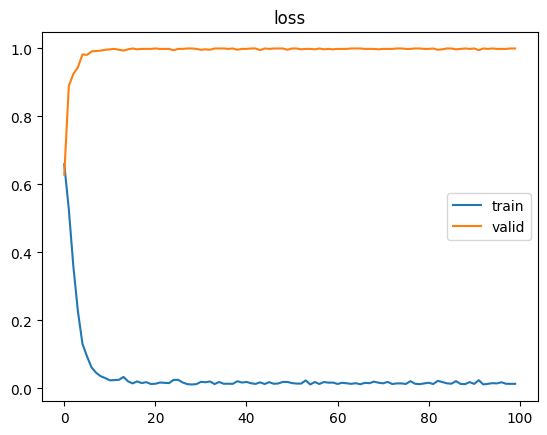

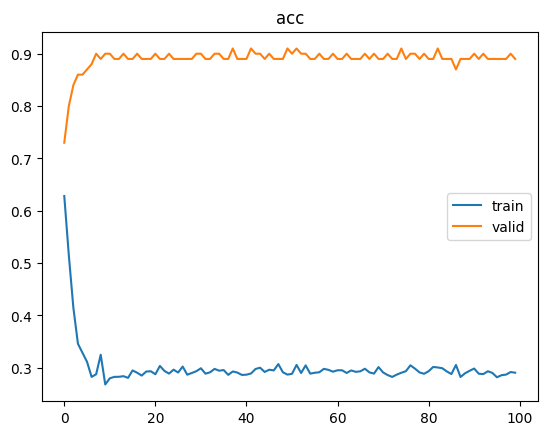

In [57]:
import matplotlib.pyplot as plt

plt.title("loss")
plt.plot(resnet34[0], label="train")
plt.plot(resnet34[1], label="valid")
plt.legend()
plt.show()

plt.title("acc")
plt.plot(resnet34[2], label="train")
plt.plot(resnet34[3], label="valid")
plt.legend()
plt.show()

In [58]:
project_root = '/content/drive/MyDrive/컵퓨터비전 시즌4/6. 프로젝트/5.  정성호 vs 임재범'
test_root = f'{project_root}/test'

test_file_list = glob.glob(f'{test_root}/*/*')
random.shuffle(test_file_list)


In [59]:
IMG_SIZE = (224, 224)

test_data_transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

image_test = datasets.ImageFolder(os.path.join(data_root, 'test'),

                                  test_data_transform)

test_dataloaders = torch.utils.data.DataLoader(image_test, batch_size=16,
                                shuffle=False)
test_dataset_size = len(image_test)
class_names = image_test.classes

print(test_dataset_size)
print(class_names)

100
['Jung', 'Lim']


In [60]:
def test_model(model, loss_func, dataloader, dataset_size, device):
  since = time()
  model.eval()

  running_loss = 0.0
  running_corrects = 0

  for inputs, labels in tqdm(dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = loss_func(outputs, labels)

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / dataset_size
  epoch_acc = running_corrects.double() / dataset_size

  time_elapsed = time() - since
  print(f'Test complete in  {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Acc: {epoch_loss:.4f} Loss: {epoch_acc:.4f}')


In [65]:
resnet34 = timm.create_model('resnet34', pretrained=True, num_classes=num_class).to(device)
cp_path = f'{project_root}/model/jshljb_resnet34.pth'
resnet34.load_state_dict(torch.load(cp_path, map_location=device))

<ipython-input-65-0df97be211b6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet34.load_state_dict(torch.load(cp_path, map_location=device))


<All keys matched successfully>

In [66]:
test_model(resnet34, loss_func, test_dataloaders, test_dataset_size, device)

100%|██████████| 7/7 [00:00<00:00,  7.34it/s]

Test complete in  0m 1s
Acc: 0.2567 Loss: 0.9100


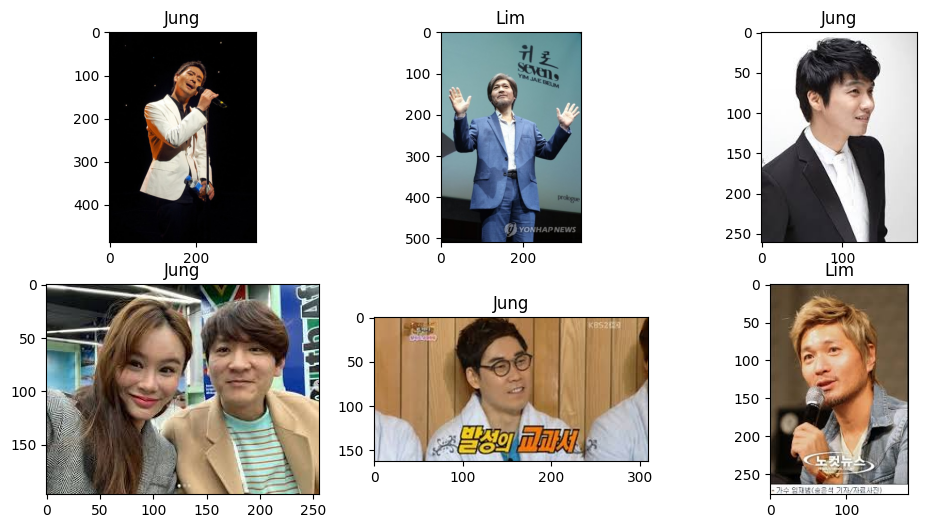

In [69]:
plt.figure(figsize=(12,6))

for idx in range(6):
  test_img_path = test_file_list[idx]
  ori_img = Image.open(test_img_path).convert('RGB')
  image = test_data_transform(ori_img)
  x_tensor = image.to(device).unsqueeze(0)


  outputs = resnet34(x_tensor)
  _, y_pred = torch.max(outputs, 1)

  plt.subplot(2,3,(idx+1))
  plt.title(class_names[y_pred])
  plt.imshow(ori_img)
plt.show()